# ASC Pan005 validation

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
from pathlib import Path
import xgcm

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35639,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:38189,Total threads: 1
Dashboard: /proxy/35533/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:36873,


In [3]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]

In [4]:
#Time variant variables
def preprocess(ds):
    ds = ds[['uo', 'vo','volcello']]
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')

In [5]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))

uC = cont['uo'].sel(yh = slice(-80, -59), z_l = slice(None, 500)).sel(time=slice('2001-01-01','2010-12-31')).mean('time')
vC = cont['vo'].sel(yq = slice(-80, -59), z_l = slice(None, 500)).sel(time=slice('2001-01-01','2010-12-31')).mean('time')

In [6]:
cont_n = xr.merge([uC,vC])
cont_n= cont_n.isel(xq = slice(1, None), yq = slice(0, None))

In [7]:
path_to_ocean_static_C = Path('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

ocean_static_C = ocean_static_C.sel(xq = cont_n['xq'], xh = cont_n['xh'], yq = cont_n['yq'], yh = cont_n['yh'])

In [8]:
grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                             'Y': {'center': 'yh', 'right': 'yq'}},
                                               periodic = ['X'])

In [9]:
dh_dx_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'X') / ocean_static_C['dxCu'], 'Y')
dh_dy_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'Y') / ocean_static_C['dyCv'], 'X')

In [10]:
uC_int = grid_C.interp(cont_n['uo'], 'Y')
vC_int = grid_C.interp(cont_n['vo'], 'X')

In [11]:
uC_int

<xarray.DataArray 'uo' (z_l: 39, yq: 967, xq: 7200)> Size: 1GB
dask.array<transpose, shape=(39, 967, 7200), dtype=float32, chunksize=(39, 512, 606), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 58kB -279.9 -279.9 -279.8 -279.8 ... 79.9 79.95 80.0
  * yq       (yq) float64 8kB -79.99 -79.97 -79.95 ... -59.06 -59.03 -59.01
Dimensions without coordinates: z_l

In [12]:
vC_int

<xarray.DataArray 'vo' (z_l: 39, yq: 967, xq: 7200)> Size: 1GB
dask.array<interp_center_to_right, shape=(39, 967, 7200), dtype=float32, chunksize=(39, 517, 600), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 58kB -279.9 -279.9 -279.8 -279.8 ... 79.9 79.95 80.0
  * yq       (yq) float64 8kB -79.99 -79.97 -79.95 ... -59.06 -59.03 -59.01
Dimensions without coordinates: z_l

In [13]:
slope_C = np.sqrt(dh_dy_C**2 + dh_dx_C**2)

In [14]:
testC = uC_int*dh_dy_C - vC_int*dh_dx_C

In [15]:
alongslope_velocity_C = testC/slope_C

In [16]:
alongslope_velocity_C = alongslope_velocity_C.astype('float32')

In [17]:
alongslope_velocity_C

<xarray.DataArray (z_l: 39, yq: 967, xq: 7200)> Size: 1GB
dask.array<truediv, shape=(39, 967, 7200), dtype=float32, chunksize=(39, 512, 600), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 58kB -279.9 -279.9 -279.8 -279.8 ... 79.9 79.95 80.0
  * yq       (yq) float64 8kB -79.99 -79.97 -79.95 ... -59.06 -59.03 -59.01
Dimensions without coordinates: z_l

In [18]:
alongslope_velocity_C = alongslope_velocity_C.load()

In [19]:
depth = xr.open_dataset(path_to_ocean_static_C)['deptho']
area = xr.open_dataset(path_to_ocean_static_C)['areacello']
var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_month_z.nc')['so'].isel(time=0,z_l=0)

In [20]:
area_corr = area*(var*0 +1)

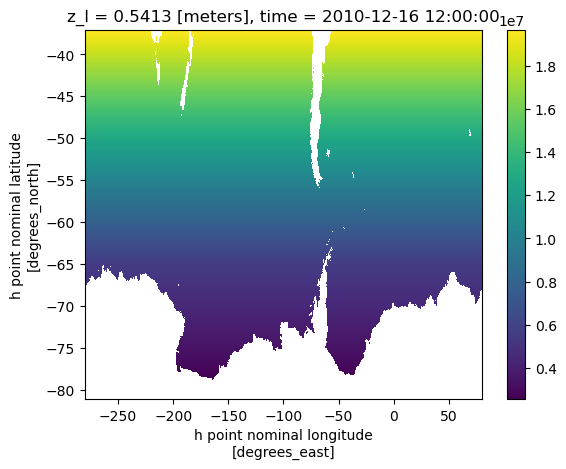

In [21]:
area_corr.plot()

In [22]:
volcello = volcello.mean(dim='time')

NameError: name 'volcello' is not defined

In [ ]:
thickness = volcello / area_corr
thickness = thickness.sel(yh=slice(-80, -59)).sel(z_l=slice(None, 500))

In [ ]:
alongslope_velocity_C

In [ ]:
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'Y')
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'X')

In [ ]:
alongslope_velocity_C

In [ ]:
alongslope_velocity_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/validation_alongslope_velocity_control_pan005.nc')

In [ ]:
barotropic_alongslope_velocity_C = (alongslope_velocity_C * thickness.sum('z_l') / thickness.sum('z_l')

In [ ]:
barotropic_alongslope_velocity_C = barotropic_alongslope_velocity_C.load()

In [ ]:
barotropic_alongslope_velocity_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/validation_barotopic_slope_velocity_control_pan005.nc')